#### 1. Install Dependencies

In [1]:
pip install -r requirements.txt -q


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#### 2. Imports & Helper Functions

In [2]:
from duckduckgo_search import DDGS
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url
from time import sleep

def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return L(DDGS().images(keywords=term, max_results=max_images)).itemgot('image')

def download_and_resize(searches, path, count=50):
    for s in searches:
        dest = (path/s)
        dest.mkdir(exist_ok=True, parents=True)    
        download_images(dest, urls=search_images(term=F'big {s} photo', max_images=count))
        download_images(dest, urls=search_images(term=F'small {s} photo', max_images=count))
        print(f"Resizing images in '{s}'")
        resize_images(path/s, max_size=400, dest=path/s)

#### 3. Main Logic

In [3]:
# download images & save each image in a folder named after the search term
# i.e. one folder per breed
searches = ['cat', 'dog']
path = Path('cats_and_dogs')
download_and_resize(searches=searches, path=path, count=25)

# some photos might not download correctly which could cause model training to fail
# remove such broken images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

Searching for 'big cat photo'
Searching for 'small cat photo'
Resizing images in 'cat'
Searching for 'big dog photo'
Searching for 'small dog photo'
Resizing images in 'dog'


1

Here what each of the DataBlock parameters means:

blocks=(ImageBlock, CategoryBlock): 
- inputs to our model are images, and the outputs are categories
- in this case, it's one of [chihuahua dog, golden retriever dog, great dane dog]

get_items=get_image_files: 
- to find all inputs to our model
- get_image_files function returns a list of all images in specified path recursively

splitter=RandomSplitter(valid_pct=0.2, seed=42): 
- split the data into training and validation sets randomly
- we are using 20% of the data for the validation set

get_y=parent_label: 
- the labels (y values) is the name of the parent dir of each file 
- i.e. the name of the folder they're in which will be one of the dog breeds

item_tfms=[Resize(192, method='squish')]: 
- before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it)

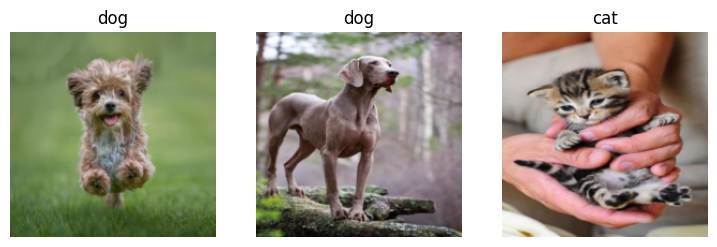

In [4]:
# create data loaders for training
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=10)

# show a few images
dls.show_batch(max_n=3)

#### 4. Train The Model

In [5]:
# fastest widely used computer vision model is resnet18
# this will take a few mins on a CPU 
# on a GPU, it will be much much faster
learn = vision_learner(dls, resnet18, metrics=error_rate)

# fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.591129,0.002330,0.527778,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.069986,0.000755,0.527778,00:03
1,0.084925,0.081540,0.527778,00:03
2,0.091678,0.000442,0.527778,00:03
3,0.108712,0.011322,0.527778,00:03
4,0.175752,0.023596,0.527778,00:03


#### 5. Predict

In [6]:
# download a random great dane image
image = 'dog.jpg'
download_url(search_images('dog photo', max_images=1)[0], image, show_progress=False)
Image.open(image).to_thumb(256, 256)

# predict the breed & display the confidence level (probability)
breed, _, probs = learn.predict(PILImage.create(image))
print(f"This is a: {breed}.")
print(f"Probability its a cat: {probs[0]:.4f}")
print(f"Probability its a dog: {probs[1]:.4f}")

Searching for 'dog photo'


This is a: dog.
Probability its a cat: 0.0000
Probability its a dog: 1.0000


#### 6. Export Model

In [7]:
# export
learn.export('cats_and_dogs.pkl')

# can then import using
# learn = load_learner('cats_and_dogs.pkl')
# learn.predict(PILImage.create('dog.jpg'))